In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier # Our chosen alternative model
from sklearn.tree import DecisionTreeClassifier # Another alternative for comparison
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving/loading models

In [30]:
# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [31]:
# Load the dataset

file_path = 'Dataset_Model_Preprocessed.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: '{file_path}' not found.")
    print("Please ensure the file is in the correct path.")
    # Create a dummy DataFrame for demonstration if file not found
    print("\nCreating a dummy dataset for demonstration purposes...")
    num_samples = 500
    ap_cols = [f'ap_{i}' for i in range(1, 44)]
    dummy_data = {}
    for col in ap_cols:
        # Simulate RSSI values, with some NaNs
        dummy_data[col] = np.random.randint(-95, -30, num_samples)
        dummy_data[col][np.random.rand(num_samples) < 0.3] = np.nan # Introduce some NaNs
    dummy_data['spot'] = np.random.choice(['Lantai 1', 'Lantai 2', 'Lantai 3', 'Lantai 4'], num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy dataset created.")
    print(df.head())

Dataset loaded successfully.
Shape of the dataset: (86, 44)

First 5 rows of the dataset:
   ap_1  ap_2  ap_3  ap_4  ap_5  ap_6  ap_7  ap_8  ap_9  ap_10  ...  ap_35  \
0 -37.0 -41.0   NaN   NaN   NaN   NaN -93.0   NaN -74.0    NaN  ...    NaN   
1 -68.0 -69.0   NaN -65.0   NaN -76.0   NaN -72.0 -79.0  -81.0  ...    NaN   
2 -53.0 -56.0   NaN -68.0   NaN -67.0 -82.0 -76.0 -76.0  -76.0  ...    NaN   
3 -69.0 -74.0 -62.0 -59.0 -87.0 -35.0 -49.0 -60.0 -75.0  -59.0  ...    NaN   
4 -63.0 -58.0   NaN -76.0   NaN -77.0   NaN   NaN -65.0  -85.0  ...    NaN   

   ap_36  ap_37  ap_38  ap_39  ap_40  ap_41  ap_42  ap_43      spot  
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  Lantai 1  
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  Lantai 1  
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  Lantai 1  
3    NaN    NaN    NaN  -83.0    NaN    NaN    NaN    NaN  Lantai 1  
4    NaN  -80.0    NaN    NaN    NaN    NaN  -72.0    NaN  Lantai 1  

[5 rows x 44 columns

In [ ]:
#Pra-pemrosesan Data
# Handle missing values: fill NaN with a placeholder (e.g., -100 for RSSI)
# -100 is a common practice for missing RSSI, indicating no signal or very weak signal.
print("\nChecking for missing values before filling:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

df.fillna(-100, inplace=True)
print("\nMissing values filled with -100.")
print("\nChecking for missing values after filling:")
print(df.isnull().sum().sum()) # Should be 0


Checking for missing values before filling:
ap_43    77
ap_42    76
ap_41    73
ap_40    73
ap_39    72
ap_38    71
ap_37    70
ap_36    69
ap_35    69
ap_33    68
dtype: int64

Missing values filled with -100.

Checking for missing values after filling:
0


In [33]:
# Define features (X) and target (y)
X = df.drop('spot', axis=1)
y = df['spot']

# Encode the target variable 'spot' (categorical for classification)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nOriginal unique spots: {le.classes_}")
print(f"Encoded spots (first 5): {y_encoded[:5]}")


Original unique spots: ['Lantai 1' 'Lantai 2' 'Lantai 3' 'Lantai 4']
Encoded spots (first 5): [0 0 0 0 0]


In [34]:
# Split data into training and testing sets
# Stratified split ensures that the proportion of classes is the same in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (64, 43), (64,)
Testing set shape: (22, 43), (22,)


In [35]:
# Scale the features
# StandardScaler transforms data to have a mean of 0 and a standard deviation of 1.
# Gradient Boosting can benefit from scaling, though less sensitive than some other models.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler.")


Features scaled using StandardScaler.



--- Data Exploration and Visualization ---


C:\Users\Rifdatun Nafi'ah\AppData\Local\Temp\ipykernel_21884\3865824963.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


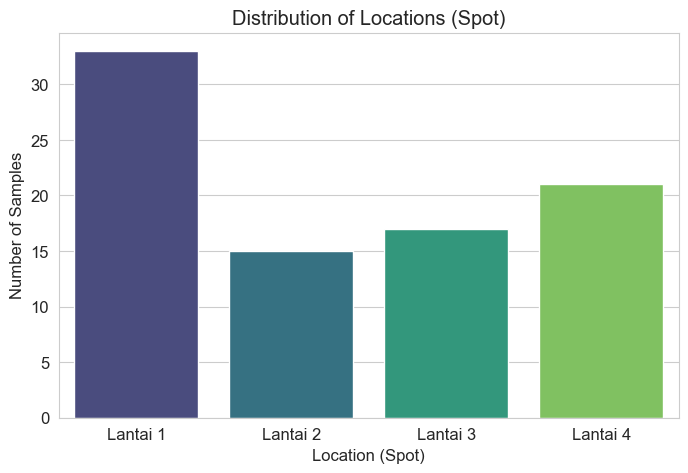

In [ ]:
#Eksplorasi Data Visual (EDA)
print("\n--- Data Exploration and Visualization ---")

# Distribution of 'spot' (target variable)
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Locations (Spot)')
plt.xlabel('Location (Spot)')
plt.ylabel('Number of Samples')
plt.show()

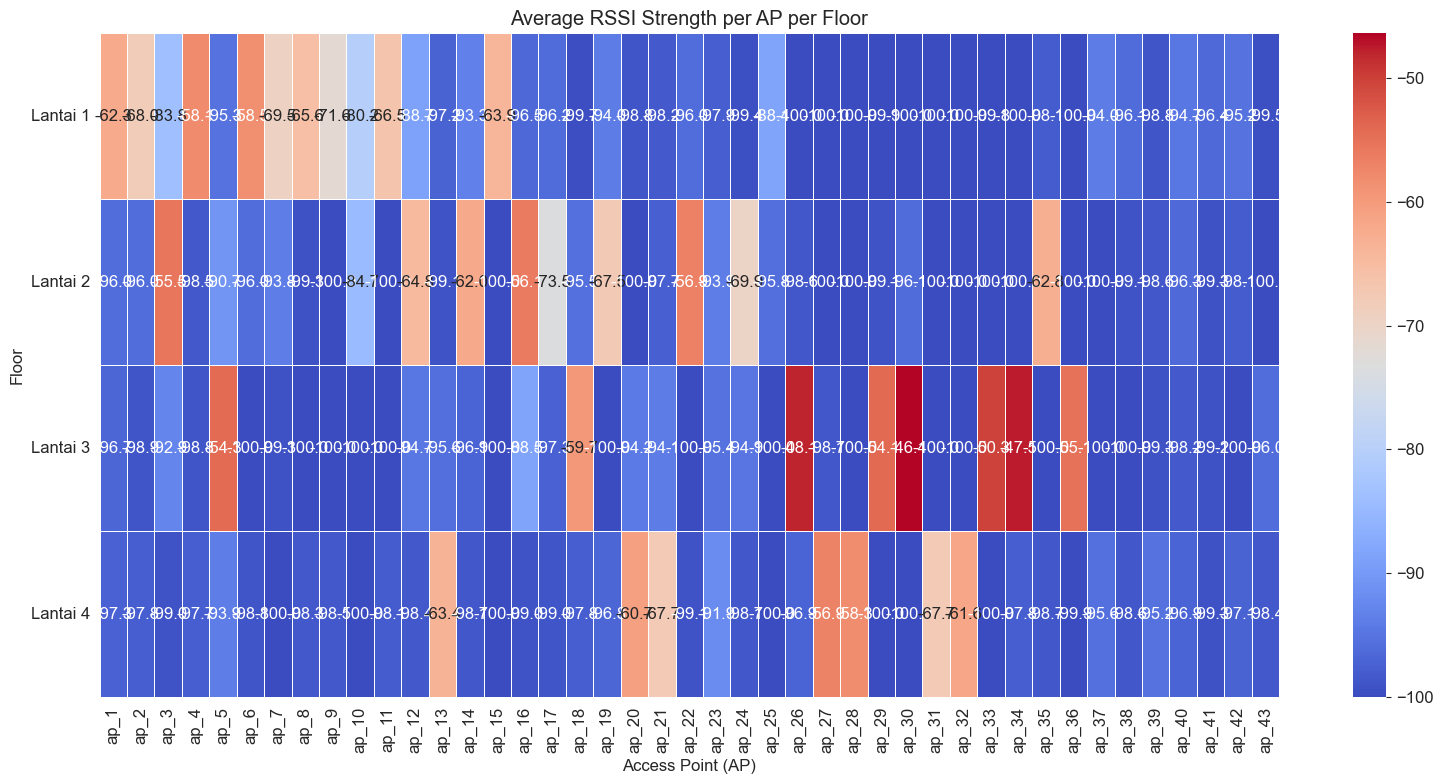

In [37]:
# Heatmap of average RSSI values per AP per Floor
# First, create a temporary DataFrame with original 'spot' and filled RSSI values
df_temp = df.copy()
df_temp['spot_original'] = y # Add original labels back for grouping

# Calculate mean RSSI for each AP per floor
avg_rssi_per_floor = df_temp.groupby('spot_original')[X.columns].mean()

plt.figure(figsize=(16, 8))
sns.heatmap(avg_rssi_per_floor, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('Average RSSI Strength per AP per Floor')
plt.xlabel('Access Point (AP)')
plt.ylabel('Floor')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\Rifdatun Nafi'ah\AppData\Local\Temp\ipykernel_21884\378785885.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spot_original', y=ap, data=df_temp, palette='plasma')
C:\Users\Rifdatun Nafi'ah\AppData\Local\Temp\ipykernel_21884\378785885.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spot_original', y=ap, data=df_temp, palette='plasma')
C:\Users\Rifdatun Nafi'ah\AppData\Local\Temp\ipykernel_21884\378785885.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='spot_original', y=ap, data=df_temp, palette='plasma')
C:\User

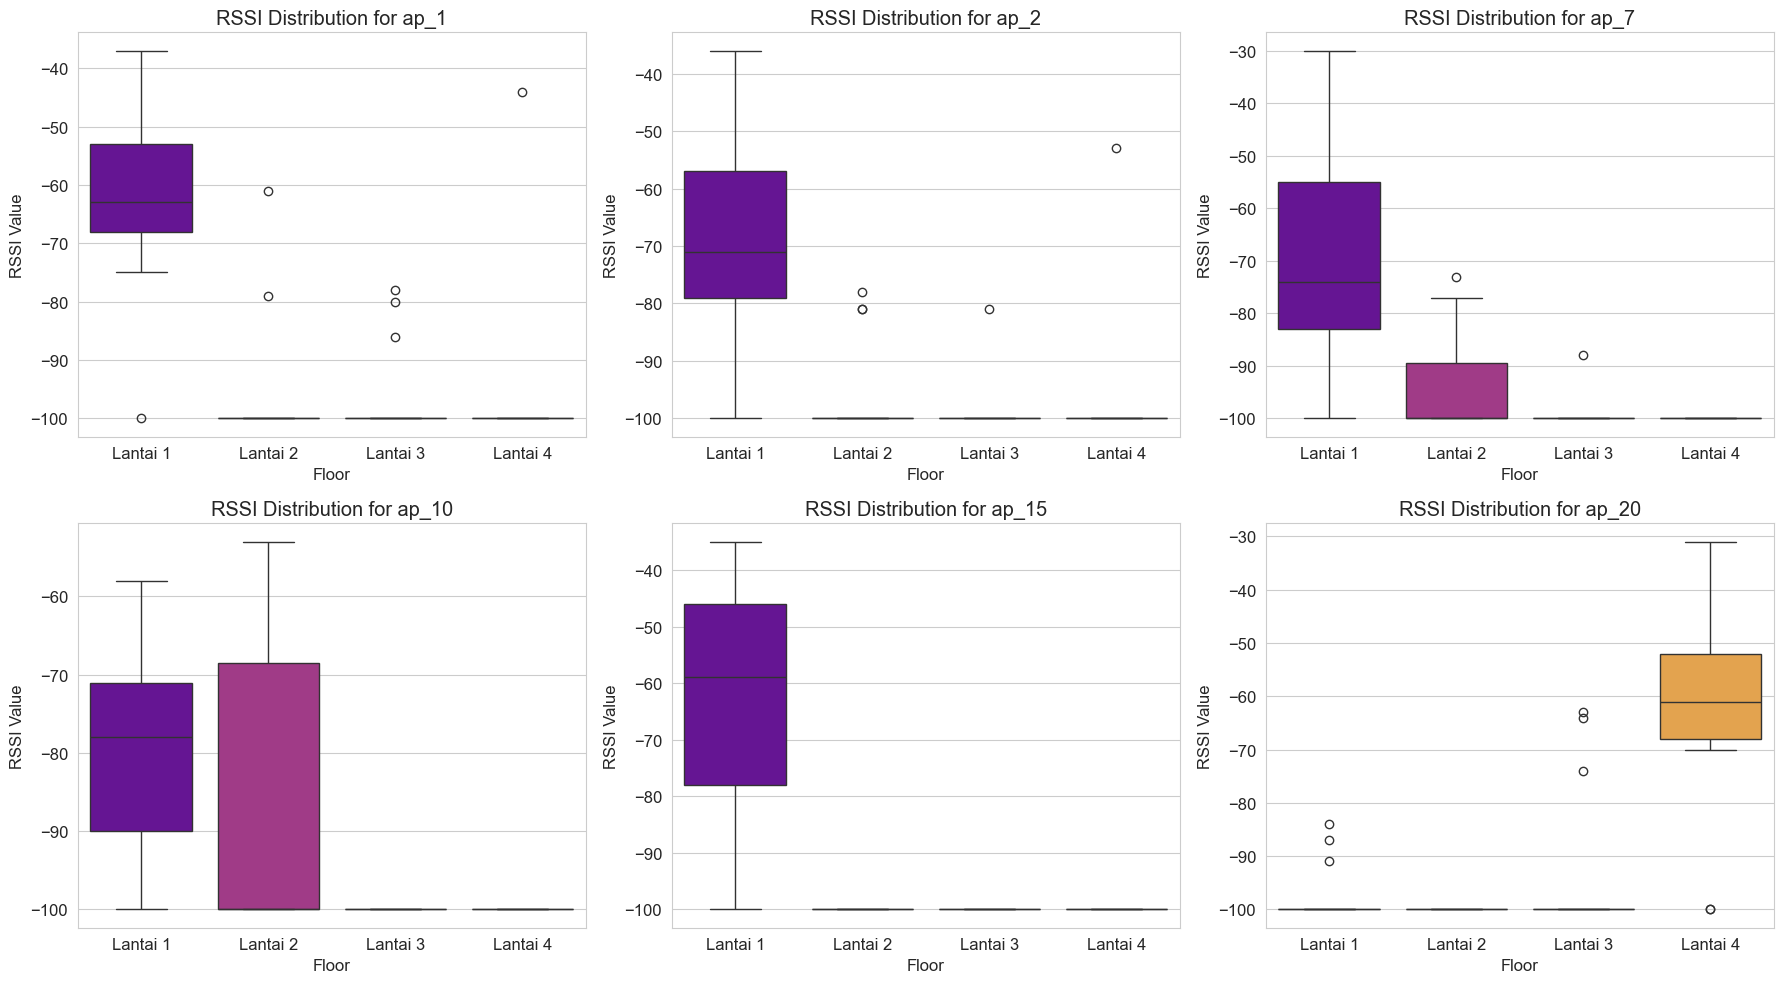

In [38]:
# Box plot of RSSI values for a few selected APs across different floors
# Select a few APs that might show good variation
selected_aps = ['ap_1', 'ap_2', 'ap_7', 'ap_10', 'ap_15', 'ap_20']
plt.figure(figsize=(18, 10))
for i, ap in enumerate(selected_aps):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='spot_original', y=ap, data=df_temp, palette='plasma')
    plt.title(f'RSSI Distribution for {ap}')
    plt.xlabel('Floor')
    plt.ylabel('RSSI Value')
plt.tight_layout()
plt.show()

Model Gradient Boosting Classifier

In [ ]:
#Membangun dan Melatih Model Gradient Boosting Classifier


# Initialize the Gradient Boosting Classifier model
# n_estimators: number of boosting stages
# learning_rate: shrinks the contribution of each tree
# max_depth: maximum depth of the individual regression estimators
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
print("\nTraining Gradient Boosting Classifier...")
gb_model.fit(X_train_scaled, y_train)
print("Gradient Boosting Classifier training complete.")


Training Gradient Boosting Classifier...
Gradient Boosting Classifier training complete.


In [ ]:
#valuasi Model Gradient Boosting Classifier


# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test_scaled)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"\n--- Model Evaluation (Gradient Boosting Classifier) ---")
print(f"Model Accuracy: {accuracy_gb:.4f}")


--- Model Evaluation (Gradient Boosting Classifier) ---
Model Accuracy: 0.9091


In [17]:
# Classification Report
print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb, target_names=le.classes_))


Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

    Lantai 1       0.82      1.00      0.90         9
    Lantai 2       1.00      0.75      0.86         4
    Lantai 3       1.00      1.00      1.00         4
    Lantai 4       1.00      0.80      0.89         5

    accuracy                           0.91        22
   macro avg       0.95      0.89      0.91        22
weighted avg       0.93      0.91      0.91        22



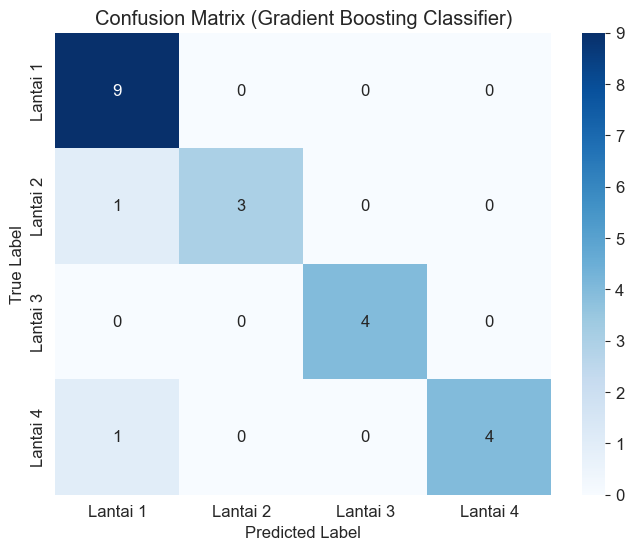

In [18]:
# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Gradient Boosting Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Decision Tree Classifier

In [ ]:
#Model: Decision Tree Classifier (for comparison)

# Initialize the Decision Tree Classifier model
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42) # Limiting depth to prevent overfitting

# Train the model
print("\nTraining Decision Tree Classifier...")
dt_model.fit(X_train_scaled, y_train)
print("Decision Tree Classifier training complete.")


Training Decision Tree Classifier...
Decision Tree Classifier training complete.


In [ ]:
#Evaluasi: Decision Tree Classifier
# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\n--- Model Evaluation (Decision Tree Classifier) ---")
print(f"Model Accuracy: {accuracy_dt:.4f}")

# Classification Report
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))


--- Model Evaluation (Decision Tree Classifier) ---
Model Accuracy: 0.8636

Classification Report (Decision Tree):
              precision    recall  f1-score   support

    Lantai 1       0.75      1.00      0.86         9
    Lantai 2       1.00      0.50      0.67         4
    Lantai 3       1.00      1.00      1.00         4
    Lantai 4       1.00      0.80      0.89         5

    accuracy                           0.86        22
   macro avg       0.94      0.82      0.85        22
weighted avg       0.90      0.86      0.86        22



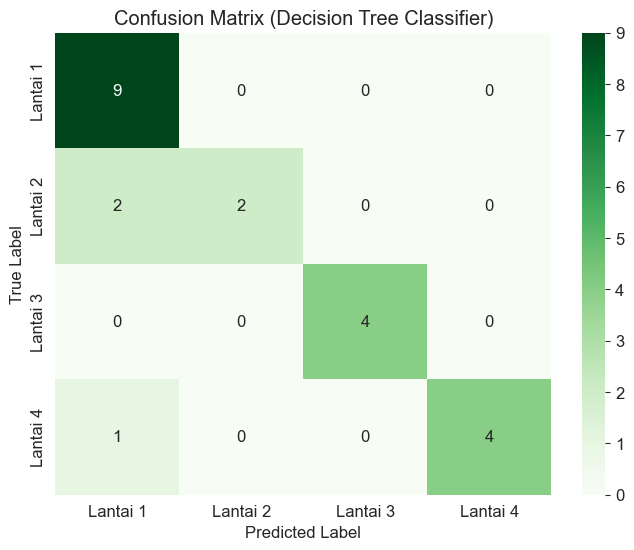

In [21]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Decision Tree Classifier)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
#Tuning Hyperparameter dengan GridSearchCV (untuk Gradient Boosting)
# Define the parameter grid for GridSearchCV for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0], # Fraction of samples to be used for fitting the individual base learners.
    'max_features': ['sqrt', None] # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                              param_grid=param_grid_gb,
                              cv=5,
                              n_jobs=-1,
                              verbose=2,
                              scoring='accuracy')

print("\n--- Starting GridSearchCV for Gradient Boosting hyperparameter tuning ---")
grid_search_gb.fit(X_train_scaled, y_train)
print("GridSearchCV complete.")


--- Starting GridSearchCV for Gradient Boosting hyperparameter tuning ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV complete.


In [23]:
# Get the best parameters and best score
print(f"\nBest parameters found for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best cross-validation accuracy for Gradient Boosting: {grid_search_gb.best_score_:.4f}")


Best parameters found for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy for Gradient Boosting: 1.0000


In [24]:
# Evaluate the best Gradient Boosting model on the test set
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test_scaled)
accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
print(f"\nAccuracy of the best Gradient Boosting model on test set: {accuracy_best_gb:.4f}")

print("\nClassification Report for Best Gradient Boosting Model:")
print(classification_report(y_test, y_pred_best_gb, target_names=le.classes_))



Accuracy of the best Gradient Boosting model on test set: 0.9545

Classification Report for Best Gradient Boosting Model:
              precision    recall  f1-score   support

    Lantai 1       0.90      1.00      0.95         9
    Lantai 2       1.00      1.00      1.00         4
    Lantai 3       1.00      1.00      1.00         4
    Lantai 4       1.00      0.80      0.89         5

    accuracy                           0.95        22
   macro avg       0.97      0.95      0.96        22
weighted avg       0.96      0.95      0.95        22



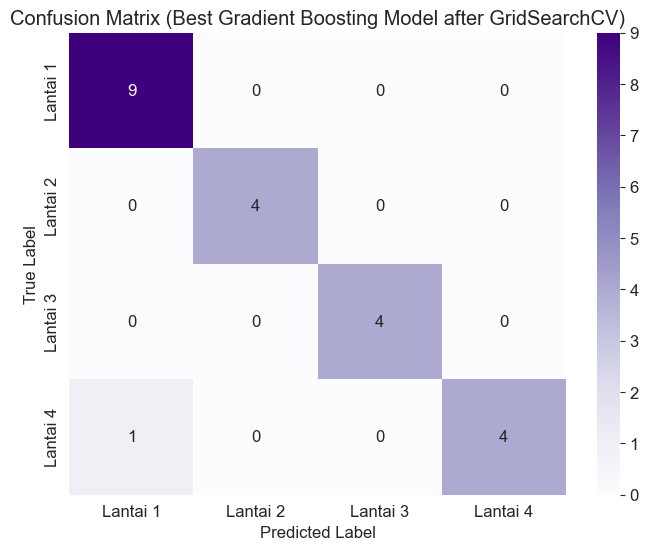

In [25]:
# Confusion Matrix for Best Gradient Boosting Model
cm_best_gb = confusion_matrix(y_test, y_pred_best_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_gb, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Best Gradient Boosting Model after GridSearchCV)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Analisis Pentingnya Fitur (untuk Gradient Boosting)


# Get feature importances from the best Gradient Boosting model
importances_gb = best_gb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})
feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance', ascending=False)

print("\n--- Top 15 Feature Importances (from Best Gradient Boosting Model) ---")
print(feature_importance_df_gb.head(15))



--- Top 15 Feature Importances (from Best Gradient Boosting Model) ---
   Feature  Importance
3     ap_4    0.070685
20   ap_21    0.069234
8     ap_9    0.065777
33   ap_34    0.064979
1     ap_2    0.059037
26   ap_27    0.054813
28   ap_29    0.048960
35   ap_36    0.043802
32   ap_33    0.037976
21   ap_22    0.032652
19   ap_20    0.032168
31   ap_32    0.031510
23   ap_24    0.028939
12   ap_13    0.028547
15   ap_16    0.024181


C:\Users\Rifdatun Nafi'ah\AppData\Local\Temp\ipykernel_21884\3156427249.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df_gb.head(15), palette='magma')


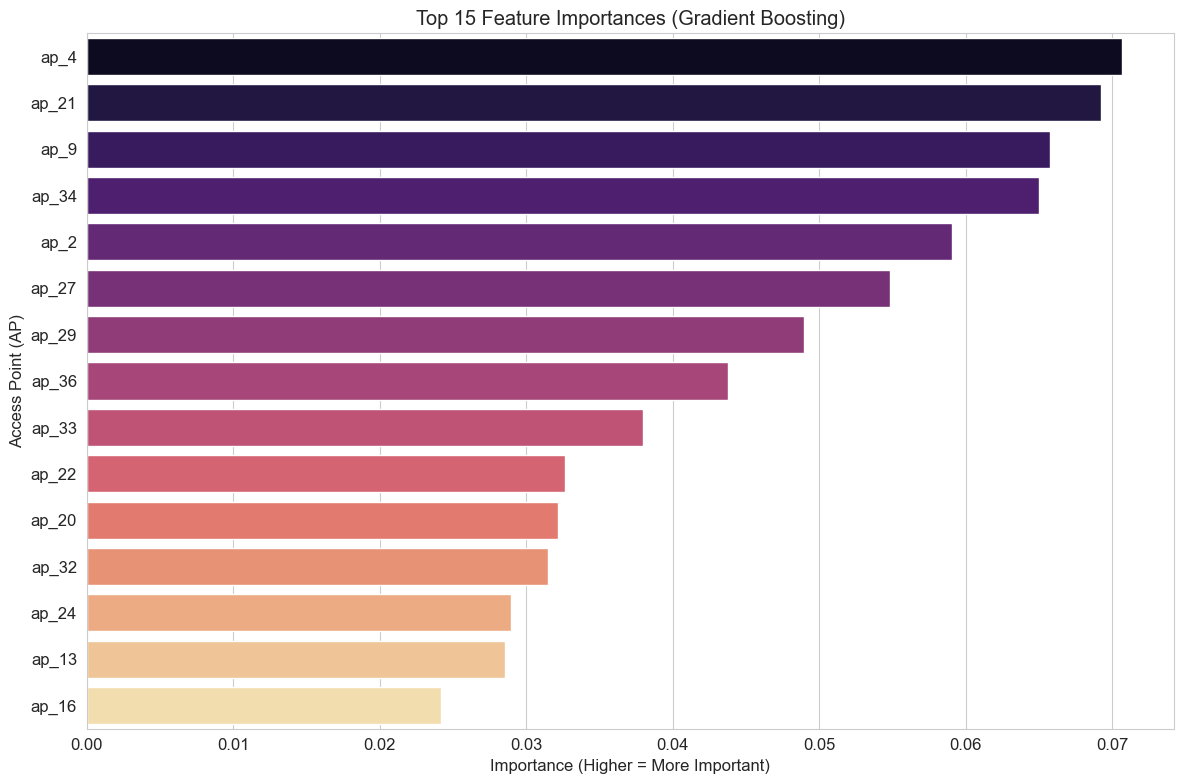

In [27]:
# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_gb.head(15), palette='magma')
plt.title('Top 15 Feature Importances (Gradient Boosting)')
plt.xlabel('Importance (Higher = More Important)')
plt.ylabel('Access Point (AP)')
plt.tight_layout()
plt.show()

In [28]:
# Save the scaler and label encoder as well
scaler_filename = 'scaler.joblib'
label_encoder_filename = 'label_encoder.joblib'
joblib.dump(scaler, scaler_filename)
joblib.dump(le, label_encoder_filename)
print(f"Scaler saved as {scaler_filename}")
print(f"Label Encoder saved as {label_encoder_filename}")


Scaler saved as scaler.joblib
Label Encoder saved as label_encoder.joblib
